# Setup and Config

In [3]:
#import packages
from sqlalchemy import create_engine
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Config MySQL credential in localhost
user ='root'
password ='root'
host ='localhost'
port = 3306
database = 'grocery_sales'

# Format connection string SQLAlchemy
connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}'

# Create engine connection
engine = create_engine(connection_string)

# Data Prepartion

In [5]:
# Query for Weekly Data
weekly_data = "SELECT * FROM ct_forecast_business_main_metrics_weekly"

# Formatting query result to DataFrame
df_weekly = pd.read_sql(weekly_data,con = engine)

# Data Preview
pd.options.display.float_format = '{:,.2f}'.format #formatting the numbers to be come readable
print(df_weekly.head())

   week_key  total_order  total_revenue  total_discount
0  2018-W01       362796  18,440,597.70       10,794.70
1  2018-W02       361996  18,400,902.74       10,855.70
2  2018-W03       363233  18,469,983.84       10,909.80
3  2018-W04       363683  18,469,668.27       10,930.00
4  2018-W05       362496  18,447,214.80       10,812.70


# Forecasting

## Forecasting - Weekly

### Forecasting - Weekly - Order

In [8]:
# rename column to follow Prophet prerequisite
df_weekly_prophet_order = df_weekly.rename(columns = {'week_key':'ds','total_order':'y'} )

# reformat 'ds' or 'week_key' to have datetime format, since it's week then took the first day of the week (Monday)
df_weekly_prophet_order['ds'] = pd.to_datetime(df_weekly_prophet_order['ds'] + '-1', format='%G-W%V-%u')

print(df_weekly_prophet_order.head())
print(df_weekly_prophet_order['ds'].dtype)

          ds       y  total_revenue  total_discount
0 2018-01-01  362796  18,440,597.70       10,794.70
1 2018-01-08  361996  18,400,902.74       10,855.70
2 2018-01-15  363233  18,469,983.84       10,909.80
3 2018-01-22  363683  18,469,668.27       10,930.00
4 2018-01-29  362496  18,447,214.80       10,812.70
datetime64[ns]


17:26:03 - cmdstanpy - INFO - Chain [1] start processing
17:26:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_6848\122803950.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_weekly_order['total_discount'].fillna(avg_discount, inplace=True)
C:\Users\yusuf\AppData\Local\Temp\ipykernel_6848\122803950.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


           ds       yhat  yhat_lower  yhat_upper
49 2018-12-10 365,491.84  193,992.15  540,353.39
50 2018-12-17 365,563.87  183,320.05  548,223.54
51 2018-12-24 365,635.89  172,792.17  559,153.98
52 2018-12-31 365,707.92  164,423.98  569,690.15
53 2019-01-07 365,779.95  152,262.89  577,706.21


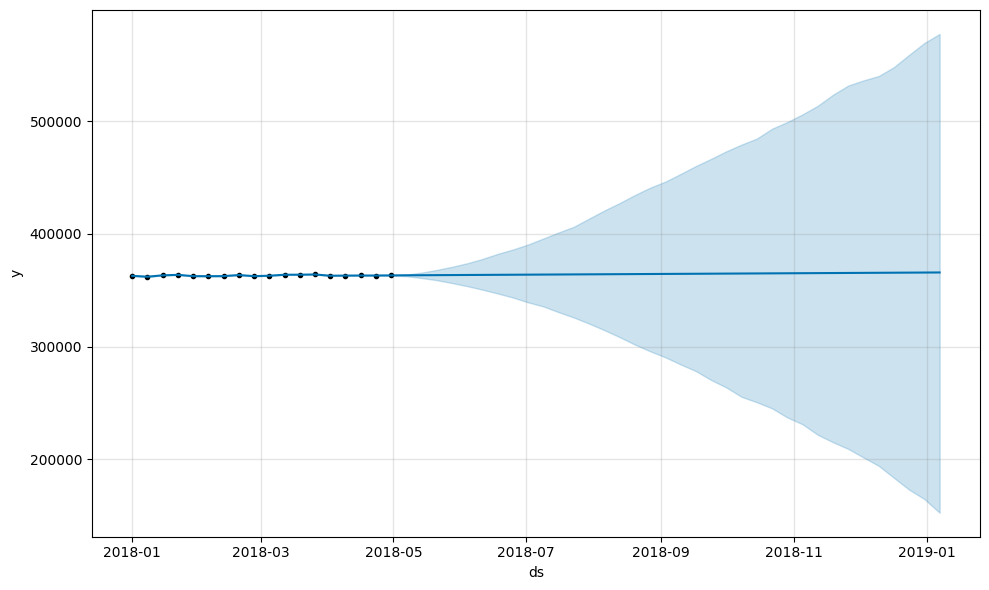

In [30]:
# create Prophet's Model
m_weekly_order = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_weekly_prophet_order['ds'].max())

# Convert the last_date using first date of the week (Monday)
last_date = last_date - pd.to_timedelta(last_date.weekday(), unit='D')

end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_days = (end_of_year - last_date).days

# Converting to full week, adding +1 to be inclusive for last week
forecast_weeks = (forecast_days // 7) + 1

# Add variable discount as additional regressor
m_weekly_order.add_regressor('total_discount')

# Fit model to the data
m_weekly_order.fit(df_weekly_prophet_order)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_weekly_order = m_weekly_order.make_future_dataframe(periods= forecast_weeks, freq='W-MON')

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_weekly_prophet_order['ds'] = pd.to_datetime(df_weekly_prophet_order['ds'])
future_weekly_order['ds'] = pd.to_datetime(future_weekly_order['ds'])

future_weekly_order = future_weekly_order.merge(
    df_weekly_prophet_order[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_weekly_prophet_order['total_discount'].mean()
future_weekly_order['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_weekly_order = m_weekly_order.predict(future_weekly_order)

# Show the prediction result for few last rows
print(future_weekly_order[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m_weekly_order.plot(future_weekly_order)
fig.show()



### Forecasting - Weekly - Order Evaluation Model

In [32]:
# Parse data to have same data type
df_weekly_prophet_order['ds'] = pd.to_datetime(df_weekly_prophet_order['ds'])
future_weekly_order['ds'] = pd.to_datetime(future_weekly_order['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_weekly_order = df_weekly_prophet_order.merge(future_weekly_order[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_weekly_order_eval = df_merged_weekly_order[df_merged_weekly_order['yhat'].notnull()]

# Calculate MAE
mae_weekly_order = mean_absolute_error(df_weekly_order_eval['y'], df_weekly_order_eval['yhat'])
print(f'MAE Weekly Order: {mae_weekly_order:.2f}')

# Calculate MAPE
mape_weekly_revenue = np.mean(np.abs((df_weekly_order_eval['y'] - df_weekly_order_eval['yhat']) / df_weekly_order_eval['y'])) * 100
print(f'MAPE Weekly Order: {mape_weekly_revenue:.2f}%')


MAE Weekly Order: 54.12
MAPE Weekly Order: 0.01%


### Forecasting - Weekly - Revenue

In [33]:
# rename column to follow Prophet prerequisite
df_weekly_prophet_revenue = df_weekly.rename(columns = {'week_key':'ds','total_revenue':'y'} )

# reformat 'ds' or 'week_key' to have datetime format, since it's week then took the first day of the week (Monday)
df_weekly_prophet_revenue['ds'] = pd.to_datetime(df_weekly_prophet_revenue['ds'] + '-1', format='%G-W%V-%u')

print(df_weekly_prophet_revenue.head())
print(df_weekly_prophet_revenue['ds'].dtype)

          ds  total_order             y  total_discount
0 2018-01-01       362796 18,440,597.70       10,794.70
1 2018-01-08       361996 18,400,902.74       10,855.70
2 2018-01-15       363233 18,469,983.84       10,909.80
3 2018-01-22       363683 18,469,668.27       10,930.00
4 2018-01-29       362496 18,447,214.80       10,812.70
datetime64[ns]


17:26:57 - cmdstanpy - INFO - Chain [1] start processing
17:26:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_6848\1889120418.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_weekly_revenue['total_discount'].fillna(avg_discount, inplace=True)


           ds          yhat    yhat_lower    yhat_upper
49 2018-12-10 18,684,716.14 11,239,931.16 25,693,516.13
50 2018-12-17 18,691,577.10 10,866,112.32 25,883,233.17
51 2018-12-24 18,698,438.05 10,520,413.85 26,331,380.36
52 2018-12-31 18,705,299.01 10,180,520.84 26,690,707.31
53 2019-01-07 18,712,159.97  9,765,465.10 27,029,352.84


C:\Users\yusuf\AppData\Local\Temp\ipykernel_6848\1889120418.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


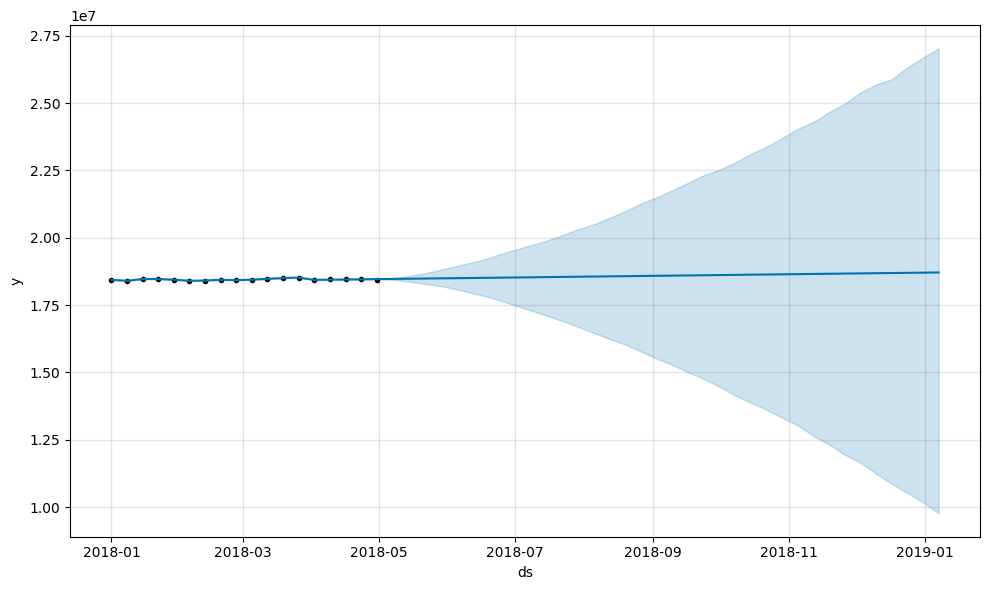

In [34]:
# create Prophet's Model
m_weekly_revenue = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_weekly_prophet_order['ds'].max())

# Convert the last_date using first date of the week (Monday)
last_date = last_date - pd.to_timedelta(last_date.weekday(), unit='D')

end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_days = (end_of_year - last_date).days

# Converting to full week, adding +1 to be inclusive for last week
forecast_weeks = (forecast_days // 7) + 1

# Add variable discount as additional regressor
m_weekly_revenue.add_regressor('total_discount')

# Fit model to the data
m_weekly_revenue.fit(df_weekly_prophet_revenue)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_weekly_revenue = m_weekly_revenue.make_future_dataframe(periods= forecast_weeks, freq='W-MON')

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_weekly_prophet_revenue['ds'] = pd.to_datetime(df_weekly_prophet_revenue['ds'])
future_weekly_revenue['ds'] = pd.to_datetime(future_weekly_revenue['ds'])

future_weekly_revenue = future_weekly_revenue.merge(
    df_weekly_prophet_revenue[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_weekly_prophet_revenue['total_discount'].mean()
future_weekly_revenue['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_weekly_revenue = m_weekly_revenue.predict(future_weekly_revenue)

# Show the prediction result for few last rows
print(future_weekly_revenue[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m_weekly_revenue.plot(future_weekly_revenue)
fig.show()



### Forecasting - Weekly - Revenue Evaluation Model

In [35]:
# Parse data to have same data type
df_weekly_prophet_revenue['ds'] = pd.to_datetime(df_weekly_prophet_revenue['ds'])
future_weekly_revenue['ds'] = pd.to_datetime(future_weekly_revenue['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_weekly_revenue = df_weekly_prophet_revenue.merge(future_weekly_revenue[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_weekly_revenue_eval = df_merged_weekly_revenue[df_merged_weekly_revenue['yhat'].notnull()]

# Calculate MAE
mae_weekly_revenue = mean_absolute_error(df_weekly_revenue_eval['y'], df_weekly_revenue_eval['yhat'])
print(f'MAE Weekly Revenue: {mae_weekly_revenue:.2f}')

# Calculate MAPE
mape_weekly_revenue = np.mean(np.abs((df_weekly_revenue_eval['y'] - df_weekly_revenue_eval['yhat']) / df_weekly_revenue_eval['y'])) * 100
print(f'MAPE Weekly Revenue: {mape_weekly_revenue:.2f}%')


MAE Weekly Revenue: 5064.36
MAPE Weekly Revenue: 0.03%


### Forecasting - Weekly - Order & Revenue

In [42]:
# Data forecasting Order
data_export_weekly_order = future_weekly_order[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
# print(data_export_daily_order.tail())

# Data forecasting Revenue
data_export_weekly_revenue = future_weekly_revenue[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
# print(data_export_daily_revenue.tail())

# Rename 'ds' to 'date_key'
data_export_weekly_order = data_export_weekly_order.rename(columns={'ds': 'period_key'})
data_export_weekly_revenue = data_export_weekly_revenue.rename(columns={'ds': 'period_key'})

# Adding prefix to each column aside 'date_key' column
order_cols = [col for col in data_export_weekly_order.columns if col != 'period_key']
data_export_weekly_order = data_export_weekly_order.rename(columns={col: 'order_' + col for col in order_cols})

revenue_cols = [col for col in data_export_weekly_revenue.columns if col != 'period_key']
data_export_weekly_revenue = data_export_weekly_revenue.rename(columns={col: 'revenue_' + col for col in revenue_cols})

# Convert date_key have datetime data_type
data_export_weekly_order['period_key'] = pd.to_datetime(data_export_weekly_order['period_key'])
data_export_weekly_revenue['period_key'] = pd.to_datetime(data_export_weekly_revenue['period_key'])

# Combined daily forecast order and forecast revenue
data_export_forecast_weekly = pd.merge(data_export_weekly_order, data_export_weekly_revenue, on='period_key', how='outer')

# Add additional column for data labeling period
data_export_forecast_weekly['forecast_granularity'] = 'forecast_weekly'
data_export_forecast_weekly['model_used'] = 'prophet'

# Check the result
print(data_export_forecast_weekly.tail())
data_export_forecast_weekly.info()

   period_key  order_yhat  order_yhat_lower  order_yhat_upper  order_trend  \
49 2018-12-10  365,491.84        193,992.15        540,353.39   365,491.84   
50 2018-12-17  365,563.87        183,320.05        548,223.54   365,563.87   
51 2018-12-24  365,635.89        172,792.17        559,153.98   365,635.89   
52 2018-12-31  365,707.92        164,423.98        569,690.15   365,707.92   
53 2019-01-07  365,779.95        152,262.89        577,706.21   365,779.95   

    order_trend_lower  order_trend_upper  revenue_yhat  revenue_yhat_lower  \
49         193,979.89         540,241.38 18,684,716.14       11,239,931.16   
50         183,449.03         548,292.84 18,691,577.10       10,866,112.32   
51         172,810.23         559,088.69 18,698,438.05       10,520,413.85   
52         164,394.30         569,720.39 18,705,299.01       10,180,520.84   
53         152,176.14         577,674.85 18,712,159.97        9,765,465.10   

    revenue_yhat_upper  revenue_trend  revenue_trend_lower  \


### Push Data to Database

In [43]:
# Table target
table_name = 'ct_groceries_forecast_result'

# Push data to MySQL
data_export_forecast_weekly.to_sql (
    name=table_name, 
    con=engine,
    if_exists='append',
    index=False
)
print("Data has been sucessfully push to database:", table_name)

Data has been sucessfully push to database: ct_groceries_forecast_result
